In [76]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt


In [77]:
import pathlib

data_dir = pathlib.Path('C:\\Users\\icosane\\Desktop\\New folder\\lorenz_chen').with_suffix('')


In [78]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

2520


In [79]:
xy = list(data_dir.glob('xy/*'))

In [80]:
batch_size = 32
img_height = 554
img_width = 413

In [81]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2520 files belonging to 6 classes.
Using 2016 files for training.


In [82]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2520 files belonging to 6 classes.
Using 504 files for validation.


In [83]:
class_names = train_ds.class_names
print(class_names)

['chen xy', 'chen zx', 'chen zy', 'lorenz xy', 'lorenz zx', 'lorenz zy']


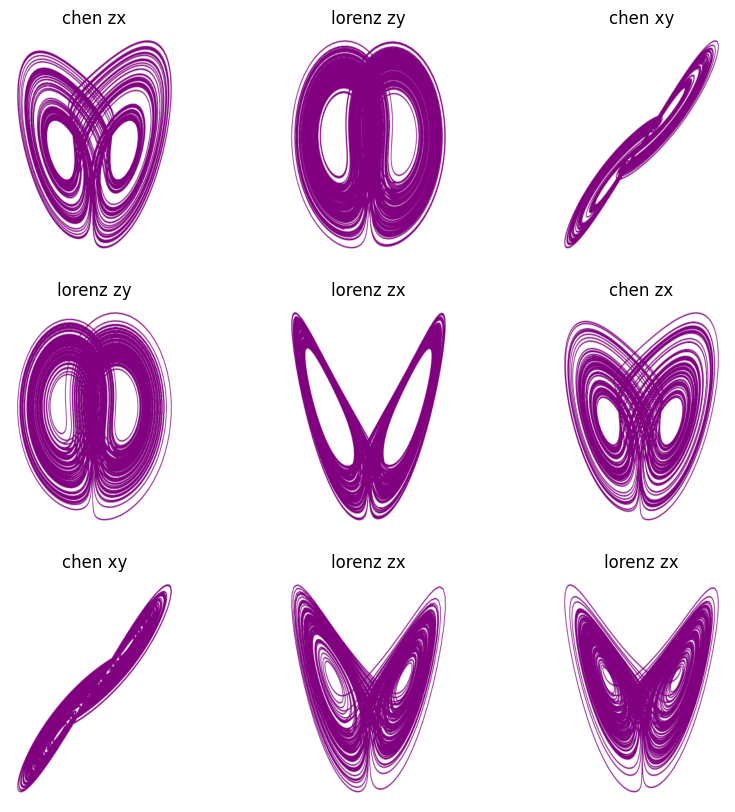

In [84]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [85]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [86]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [87]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [88]:
num_classes = 6


model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [89]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [90]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1
)

63/63 [==============================] - 158s 2s/step - loss: 0.2915 - accuracy: 0.9241 - val_loss: 4.2912e-04 - val_accuracy: 1.0000


In [91]:
model.evaluate(val_ds)

16/16 [==============================] - 7s 420ms/step - loss: 4.2912e-04 - accuracy: 1.0000


[0.00042911642231047153, 1.0]

In [92]:
for test_images, test_labels in val_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

predictions.shape
predictions[1]
np.argmax(predictions[0])
test_labels[1]

1/1 [==============================] - 1s 518ms/step


5

In [93]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array = predictions_array[i]
  true_label = true_labels[i] 
  img = images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100 * np.max(predictions_array),
                                      class_names[true_label]),
                                      color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array = predictions_array[i]
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks([0,1,2,3,4,5,6,7,8,9])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

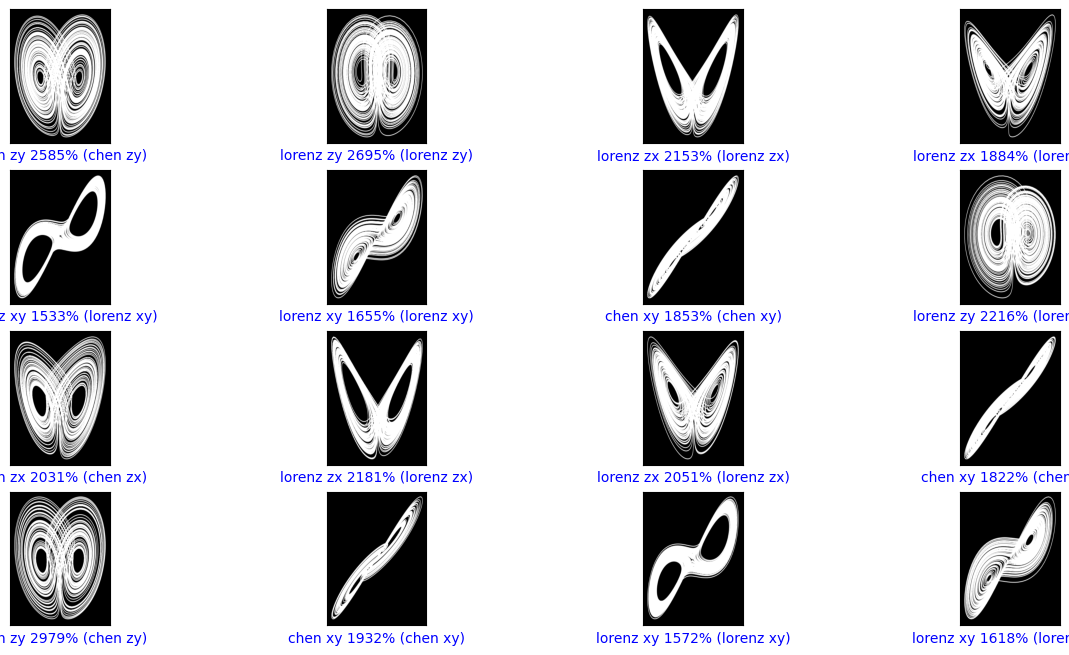

In [94]:
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_rows, 2*num_cols))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i + 1)
  plot_image(i, predictions, test_labels, test_images)

In [95]:
model.save("C:\\Users\\icosane\\Desktop\\New folder\\chen\\_chen_model.h5")

c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [96]:
from tensorflow.keras.models import load_model
sm_model = load_model('C:\\Users\\icosane\\Desktop\\New folder\\chen\\_chen_model.h5')

test_score = sm_model.evaluate(test_images, test_labels, verbose=1)
print('Test Loss:', test_score[0])
print('Test Accuracy:', test_score[1])

1/1 [==============================] - 1s 636ms/step - loss: 1.0430e-04 - accuracy: 1.0000
Test Loss: 0.0001042965377564542
Test Accuracy: 1.0


In [97]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)
cr = classification_report(y_true, y_pred, output_dict=True, target_names=class_names)
pd.DataFrame.from_dict(cr)

16/16 [==============================] - 7s 419ms/step


,chen xy,chen zx,chen zy,lorenz xy,lorenz zx,lorenz zy,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
support,89.0,80.0,87.0,88.0,85.0,75.0,1.0,504.0,504.0


In [100]:
cm = confusion_matrix(val_ds, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [16, 504]